In [1]:
# Cell 1: Import Libraries and Load Full Data
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import os
import gc
from typing import Dict, List, Tuple, Set # Added for type hinting consistency
import pickle
import matplotlib.pyplot as plt # Added for plotting

# --- Configuration ---
pd.set_option('display.max_columns', None)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# --- Load Data ---
# Use the same paths as the original matrix.ipynb
recommendations_path = os.path.join(BASE_DIR, "data/external/recommendations.csv")
games_path = os.path.join(BASE_DIR, "data/external/games_tagged.csv")

# --- Load Full Recommendations Data ---
print(f"Loading recommendations from: {recommendations_path}")
# Use the original df name from matrix.ipynb for consistency within this file
df = pd.read_csv(recommendations_path)
df['app_id'] = df['app_id'].astype(int) # Ensure app_id is int
print(f"Loaded {len(df):,} full recommendations records.")

# --- Filter to keep only positive interactions (similar to Colab) ---
print(f"\nFiltering recommendations to keep only positive interactions ('is_recommended_binary == 1')...")
original_count = len(df)
df = df[df['is_recommended_binary'] == 1].copy()
filtered_count = len(df)
print(f"Filtered from {original_count:,} to {filtered_count:,} positive recommendation records.")
# Verify the filter worked
print(f"Unique values in 'is_recommended_binary' after filtering: {df['is_recommended_binary'].unique()}")


# --- Load Game Metadata ---
print(f"\nLoading game metadata from: {games_path}")
# Use the original games name from matrix.ipynb
games = pd.read_csv(games_path)
games['app_id'] = games['app_id'].astype(int) # Ensure app_id is int
print(f"Loaded {len(games):,} games metadata records.")

# --- Remove Original Interaction Score Calculation ---
# The interaction score creation from the original matrix.ipynb (Step 3) is removed
# as we are now focusing only on positive binary recommendations like in the Colab example.
# We also remove the fillna calls for hours_log and helpfulness_ratio as they are not used directly for matrix creation anymore.

# --- Memory Management ---
gc.collect()

Loading recommendations from: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\data/external/recommendations.csv
Loaded 41,154,794 full recommendations records.

Filtering recommendations to keep only positive interactions ('is_recommended_binary == 1')...
Filtered from 41,154,794 to 35,304,398 positive recommendation records.
Unique values in 'is_recommended_binary' after filtering: [1]

Loading game metadata from: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\data/external/games_tagged.csv
Loaded 50,872 games metadata records.


20

In [2]:
# Cell 2: Calculate Interaction Counts on Full Dataset (from Colab Cell 2)
print("Calculating interaction counts on the filtered positive recommendations...")

# Count how many positive interactions each user has
user_interaction_counts = df['user_id'].value_counts()

# Count how many positive interactions each game (app_id) has
item_interaction_counts = df['app_id'].value_counts()

print(f"Found {len(user_interaction_counts):,} unique users with positive recommendations.")
print(f"Found {len(item_interaction_counts):,} unique items (games) with positive recommendations.")

# Display some stats about the counts
print("\nUser Positive Interaction Count Stats:")
print(user_interaction_counts.describe())
print("\nItem Positive Interaction Count Stats:")
print(item_interaction_counts.describe())

# Example: See the top 5 most active users and most interacted-with games
print("\nTop 5 Users by Positive Interactions:")
print(user_interaction_counts.head())
print("\nTop 5 Items by Positive Interactions:")
print(item_interaction_counts.head())

gc.collect()

Calculating interaction counts on the filtered positive recommendations...
Found 12,663,134 unique users with positive recommendations.
Found 37,419 unique items (games) with positive recommendations.

User Positive Interaction Count Stats:
count    1.266313e+07
mean     2.787967e+00
std      6.757650e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.920000e+03
Name: count, dtype: float64

Item Positive Interaction Count Stats:
count     37419.000000
mean        943.488549
std        6725.926600
min           1.000000
25%          10.000000
50%          29.000000
75%         139.000000
max      294879.000000
Name: count, dtype: float64

Top 5 Users by Positive Interactions:
user_id
5112758     3920
5669734     3479
11553593    3392
5390510     3023
1353327     2262
Name: count, dtype: int64

Top 5 Items by Positive Interactions:
app_id
440       294879
252490    226293
292030    193139
431960    186792
730       186306
Name: count, d

0


--- Plotting Distributions (for visual reference) ---


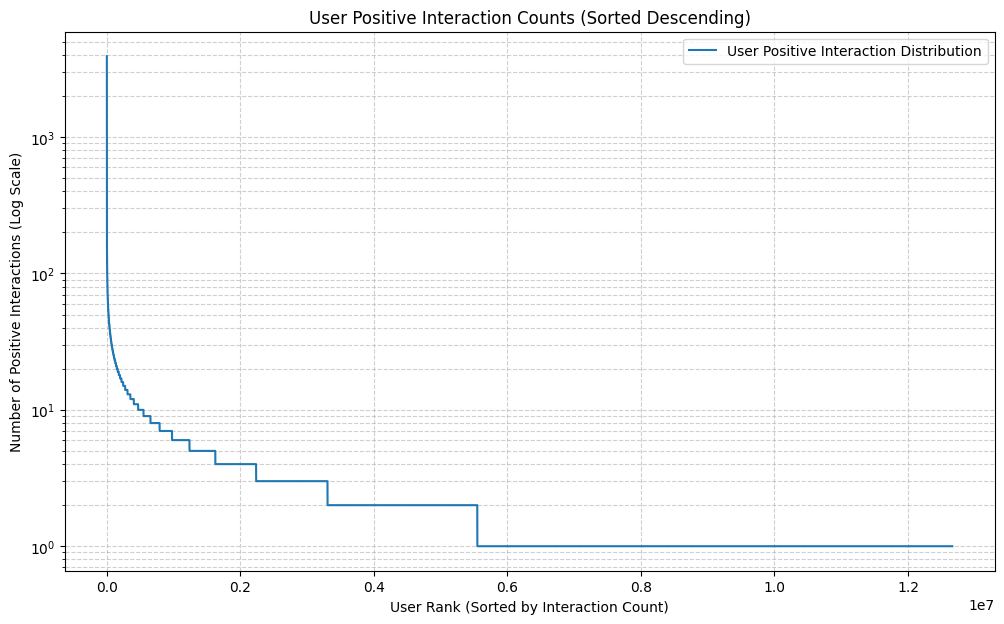

User Percentiles:
0.50     1.0
0.75     3.0
0.90     5.0
0.95     9.0
0.99    22.0
Name: count, dtype: float64


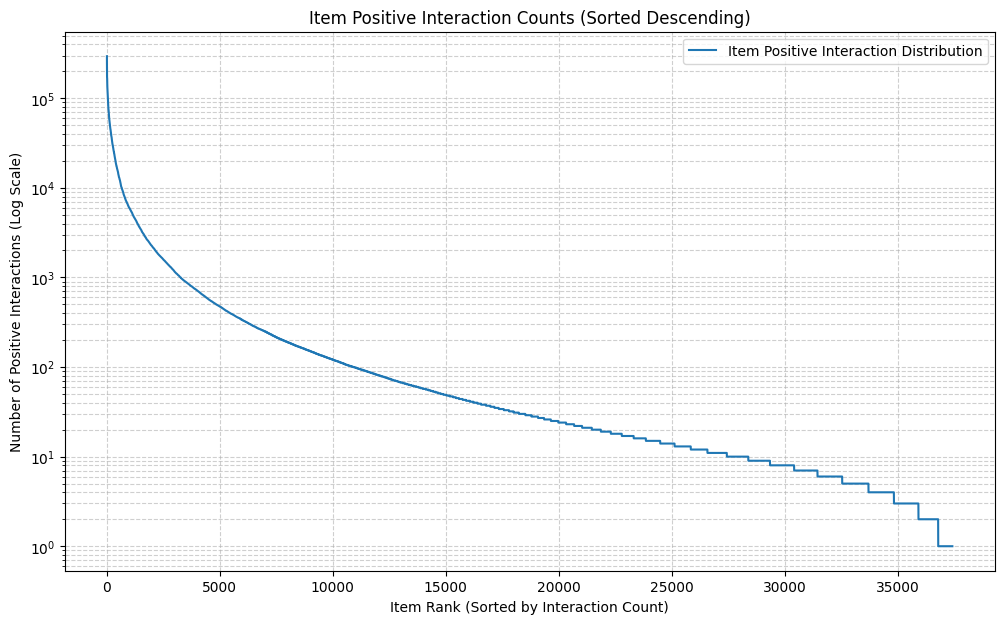


Item Percentiles:
0.50       29.00
0.75      139.00
0.90      797.00
0.95     2476.10
0.99    20194.22
Name: count, dtype: float64


In [ ]:
# Cell 3: Plot Interaction Distributions (Optional but good practice - from Colab Cell 2b)

def plot_interaction_distribution(counts_series, entity_name):
    """Plots the interaction distribution on a log scale."""
    if counts_series.empty:
        print(f"Cannot plot for {entity_name}: Series is empty.")
        return

    sorted_counts = counts_series[counts_series > 0].sort_values(ascending=False).reset_index(drop=True)
    if sorted_counts.empty:
        print(f"Cannot plot for {entity_name}: No positive counts.")
        return

    ranks = np.arange(1, len(sorted_counts) + 1)
    count_values = sorted_counts.values

    plt.figure(figsize=(12, 7))
    plt.plot(ranks, count_values, label=f'{entity_name} Positive Interaction Distribution')
    title = f'{entity_name} Positive Interaction Counts (Sorted Descending)'
    plt.title(title)
    plt.xlabel(f'{entity_name} Rank (Sorted by Interaction Count)')
    plt.ylabel('Number of Positive Interactions (Log Scale)')
    plt.yscale('log') # Use log scale to see the long tail
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

print("\n--- Plotting Distributions (for visual reference) ---")
# Plot the raw distributions without highlighting any specific elbow initially
plot_interaction_distribution(user_interaction_counts, 'User')
print("User Percentiles:")
print(user_interaction_counts.quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

plot_interaction_distribution(item_interaction_counts, 'Item')
print("\nItem Percentiles:")
print(item_interaction_counts.quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

# Note: Based on these plots and percentiles, you might adjust the thresholds below.
# The thresholds from the original matrix.ipynb are kept for now.

In [4]:
# Cell 4: Filter Interactions Based on Thresholds (Aligned with Colab Cell 3, using original matrix.ipynb thresholds)

# --- Define Thresholds (Using original matrix.ipynb values) ---
MIN_USER_INTERACTIONS = 9  # Original: 5 | Colab example: 9
MIN_ITEM_INTERACTIONS = 2476 # Original: 500 | Colab example: 2476
print(f"\nFiltering criteria: Users >= {MIN_USER_INTERACTIONS} interactions, Items >= {MIN_ITEM_INTERACTIONS} interactions.")
print(f"Note: These thresholds are from the original matrix.ipynb. Adjust based on plots/analysis if needed.")

# --- Filter Users ---
# Get the list of user_ids who meet the minimum interaction count
users_to_keep = user_interaction_counts[user_interaction_counts >= MIN_USER_INTERACTIONS].index
# Filter the main dataframe
df_filtered_users = df[df['user_id'].isin(users_to_keep)]
print(f"Interactions after user filtering: {len(df_filtered_users):,}")

# --- Filter Items ---
# Get the list of app_ids that meet the minimum interaction count
items_to_keep = item_interaction_counts[item_interaction_counts >= MIN_ITEM_INTERACTIONS].index
# Filter the dataframe that was already filtered by user
df_filtered = df_filtered_users[df_filtered_users['app_id'].isin(items_to_keep)]
print(f"Interactions after item filtering: {len(df_filtered):,}")

# --- Cleanup intermediate variables ---
del users_to_keep
del items_to_keep
del user_interaction_counts # Counts are no longer needed
del item_interaction_counts # Counts are no longer needed
del df_filtered_users
del df # Remove the original filtered df

gc.collect()


Filtering criteria: Users >= 9 interactions, Items >= 2476 interactions.
Note: These thresholds are from the original matrix.ipynb. Adjust based on plots/analysis if needed.
Interactions after user filtering: 12,148,447
Interactions after item filtering: 9,297,282


27999

In [5]:
# Cell 5: Shuffle Filtered Data (from Colab Cell 4)

SEED = 42 # For reproducible results

print(f"\nFiltered positive interaction count: {len(df_filtered):,}")
print("Shuffling the filtered data...")
# Shuffle all rows using sample(frac=1) instead of sampling a subset
# Rename to df_final for clarity
df_final = df_filtered.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"Final number of positive interactions being used (shuffled): {len(df_final):,}")

# --- Cleanup intermediate variable ---
del df_filtered
gc.collect()


Filtered positive interaction count: 9,297,282
Shuffling the filtered data...
Final number of positive interactions being used (shuffled): 9,297,282


0

In [6]:
# Cell 6: Display Sample Data and Finalize Game Metadata (from Colab Cell 5)

print("\nSample Final Recommendations Data (Filtered Positives & Shuffled):")
print(df_final[['user_id', 'app_id', 'is_recommended_binary', 'hours_log']].head()) # Show relevant columns

# Get unique game IDs from the final interaction dataset
final_game_ids = df_final['app_id'].unique()
print(f"\nUnique Games in final dataset: {len(final_game_ids):,}")

print("\nFiltering Games Metadata...")
# Keep only metadata for games present in the final interaction data
# Use the original 'games' variable
games_filtered = games[games['app_id'].isin(final_game_ids)].copy() # Use copy to avoid SettingWithCopyWarning
print(f"Retained metadata for {len(games_filtered):,} games.")

print("\nSample Filtered Games Metadata (Relevant Columns):")
print(games_filtered[['app_id', 'title', 'tags']].head())

# --- Overwrite the original 'games' dataframe with the filtered one ---
games = games_filtered

# Delete the intermediate filtered variable and the IDs list
del games_filtered
del final_game_ids
gc.collect()


Sample Final Recommendations Data (Filtered Positives & Shuffled):
   user_id   app_id  is_recommended_binary  hours_log
0  4713301   203770                      1   4.188138
1  4243479   207610                      1   2.772589
2  3066200  1172470                      1   1.648659
3   485854   526870                      1   3.740048
4  1153037   105600                      1   5.354698

Unique Games in final dataset: 1,872

Filtering Games Metadata...
Retained metadata for 1,872 games.

Sample Filtered Games Metadata (Relevant Columns):
   app_id                              title  \
2  113020       Monaco: What's Yours Is Mine   
4  249050            Dungeon of the ENDLESS™   
5  250180                       METAL SLUG 3   
6  253980                            Enclave   
8  282900  Hyperdimension Neptunia Re;Birth1   

                                                tags  
2  ['Co-op', 'Stealth', 'Indie', 'Heist', 'Local ...  
4  ['Roguelike', 'Strategy', 'Tower Defense', 'Pi...  


0

In [7]:
# Cell 7: Create Sparse User-Item Interaction Matrix (from Colab Cell 6)

print("Creating the User-Item interaction matrix from positive recommendations...")
print(f"Input data shape: {df_final.shape}")

# Since we filtered for is_recommended_binary == 1, the presence of an interaction implies a positive recommendation.
# We can use a constant value (e.g., 1) or a scaled value if desired.
# Let's use 1 for simplicity, representing the positive interaction.
interaction_value = 1

# Use pivot_table to create the matrix (Users as rows, Items as columns)
# Ensure index/columns are categorical for efficiency if memory is tight, but usually okay for IDs.
user_item_pivot = df_final.pivot_table(
    index='user_id',
    columns='app_id',
    values='is_recommended_binary', # Could use a constant 1 here too
    fill_value=0  # Fill missing interactions (NaN) with 0
)

print(f"Created pivot table with shape: {user_item_pivot.shape} (Users x Items)")

# Convert the dense pivot table to a sparse matrix (CSR format)
print("Converting pivot table to sparse matrix (CSR format)...")
user_item_sparse_matrix = csr_matrix(user_item_pivot.values)

# --- Create Mappings for Interpretation ---
# These maps are essential to link matrix rows/columns back to original IDs
user_map = {id: i for i, id in enumerate(user_item_pivot.index)}
item_map = {id: i for i, id in enumerate(user_item_pivot.columns)}

# Create inverse mappings to get IDs from matrix indices
user_map_inv = {i: id for id, i in user_map.items()}
item_map_inv = {i: id for id, i in item_map.items()}

print(f"Sparse matrix shape: {user_item_sparse_matrix.shape}")
sparsity = 1.0 - user_item_sparse_matrix.nnz / (user_item_sparse_matrix.shape[0] * user_item_sparse_matrix.shape[1])
print(f"Sparsity: {sparsity:.4%}")

# --- Cleanup ---
del user_item_pivot # Pivot table no longer needed after conversion to sparse
# df_final is kept for now, might be needed for evaluation split

gc.collect()

# --- Remove SVD related steps ---
# Steps 6 (Train/Test Split on matrix), 7 (Train SVD), 8 (Evaluate SVD RMSE/MAE)
# from the original matrix.ipynb are removed.

Creating the User-Item interaction matrix from positive recommendations...
Input data shape: (9297282, 15)
Created pivot table with shape: (651948, 1872) (Users x Items)
Converting pivot table to sparse matrix (CSR format)...
Sparse matrix shape: (651948, 1872)
Sparsity: 99.2382%


0

In [8]:
# Cell 8: Calculate Item-Item Cosine Similarity (from Colab Cell 7)

print("Calculating Item-Item cosine similarity...")

# Important: cosine_similarity expects samples as rows.
# To calculate item-item similarity, we transpose the matrix (.T) so that items become rows.
# user_item_sparse_matrix has shape (n_users, n_items)
# item_user_sparse_matrix will have shape (n_items, n_users)
item_user_sparse_matrix = user_item_sparse_matrix.T

# Calculate cosine similarity between all pairs of items
# Use dense_output=False if memory is a concern, but True is often easier for lookup
# Let's use dense_output=True as in the Colab example for simplicity here.
item_similarity_matrix = cosine_similarity(item_user_sparse_matrix, dense_output=True)

print(f"Calculated item-item similarity matrix with shape: {item_similarity_matrix.shape}")

# Ensure the diagonal is ~1 (similarity of an item with itself)
np.fill_diagonal(item_similarity_matrix, 1.0) # Force diagonal to 1.0 to avoid floating point issues
print(f"Diagonal check (should be 1.0): {item_similarity_matrix.diagonal().mean():.4f}")

# Display a small slice to verify
print("\nSlice of the similarity matrix:")
print(pd.DataFrame(item_similarity_matrix, index=item_map_inv.keys(), columns=item_map_inv.keys()).iloc[:5, :5])

# --- Cleanup ---
del item_user_sparse_matrix # Transposed matrix no longer needed
# Keep user_item_sparse_matrix for potential user-based calcs or evaluation if needed later
gc.collect()

Calculating Item-Item cosine similarity...
Calculated item-item similarity matrix with shape: (1872, 1872)
Diagonal check (should be 1.0): 1.0000

Slice of the similarity matrix:
          0         1         2         3         4
0  1.000000  0.092342  0.103621  0.087259  0.067532
1  0.092342  1.000000  0.216614  0.181394  0.169884
2  0.103621  0.216614  1.000000  0.135162  0.203312
3  0.087259  0.181394  0.135162  1.000000  0.116780
4  0.067532  0.169884  0.203312  0.116780  1.000000


0

In [10]:
# Cell 9: Define Item-Based Recommendation Function using Cosine Similarity (from Colab Cell 8)

def recommend_similar_games_cosine(target_app_id: int, top_n: int = 10) -> pd.DataFrame:
    """
    Recommends games similar to the target_app_id using the pre-calculated
    item-item cosine similarity matrix. Requires 'item_map', 'item_map_inv',
    'item_similarity_matrix', and 'games' (filtered metadata) to be in the global scope.

    Args:
        target_app_id: The app_id of the game for which to find recommendations.
        top_n: The number of similar games to return.

    Returns:
        A pandas DataFrame containing the top_n recommended games, including
        their app_id, game_name, and similarity_score. Returns an empty
        DataFrame if the target_app_id is not found in the model's data.
    """
    # --- Input Validation ---
    if target_app_id not in item_map:
        print(f"Warning: app_id {target_app_id} not found in the filtered interaction data used for the model.")
        # Attempt to find the title anyway for better warning messages
        target_game_info = games[games['app_id'] == target_app_id]
        target_game_title = target_game_info['title'].iloc[0] if not target_game_info.empty else f"ID {target_app_id}"
        print(f"Cannot generate recommendations for '{target_game_title}'. It might have been filtered out due to low interaction counts.")
        return pd.DataFrame(columns=['app_id', 'game_name', 'similarity_score'])

    # --- Get Matrix Index ---
    try:
        item_index = item_map[target_app_id]
    except KeyError:
        # This case should be caught by the check above, but added for safety
        print(f"Error: Could not find matrix index for app_id {target_app_id}, although it was expected in item_map.")
        return pd.DataFrame(columns=['app_id', 'game_name', 'similarity_score'])

    # --- Retrieve Similarity Scores ---
    # Ensure item_index is within bounds
    if not (0 <= item_index < item_similarity_matrix.shape[0]):
         print(f"Error: Calculated item_index {item_index} is out of bounds for similarity matrix shape {item_similarity_matrix.shape}.")
         return pd.DataFrame(columns=['app_id', 'game_name', 'similarity_score'])

    similarity_scores = item_similarity_matrix[item_index]

    # --- Combine Scores with Item Indices ---
    # We map matrix index -> similarity score
    item_score_pairs = list(enumerate(similarity_scores)) # Creates [(0, score0), (1, score1), ...]

    # --- Sort by Similarity ---
    # Sort by score (the second element of the tuple) in descending order
    sorted_item_score_pairs = sorted(item_score_pairs, key=lambda x: x[1], reverse=True)

    # --- Exclude Input Game & Select Top N ---
    # The first item will be the game itself (similarity=1.0), so skip it.
    top_similar_items = []
    for matrix_idx, score in sorted_item_score_pairs:
        if matrix_idx == item_index: # Skip self
             continue
        if len(top_similar_items) < top_n:
             top_similar_items.append((matrix_idx, score))
        else:
             break # Stop once we have top_n

    # --- Map Indices back to App IDs and Get Names ---
    recommendations = []
    for matrix_idx, score in top_similar_items:
        try:
            recommended_app_id = item_map_inv[matrix_idx]
            # Use the globally available 'games' DataFrame (which should be filtered)
            game_info = games[games['app_id'] == recommended_app_id]
            # Get title, provide default if somehow missing
            game_name = game_info['title'].iloc[0] if not game_info.empty else f"Title Not Found (ID: {recommended_app_id})"
            recommendations.append({
                'app_id': recommended_app_id,
                'game_name': game_name,
                'similarity_score': score
            })
        except KeyError:
             print(f"Warning: Could not map matrix index {matrix_idx} back to an app_id.")
        except IndexError:
             print(f"Warning: Could not find title for recommended app_id {recommended_app_id} in games metadata.")
        except Exception as e:
             print(f"Warning: An unexpected error occurred processing recommendation index {matrix_idx}: {e}")


    return pd.DataFrame(recommendations)

# --- Quick Test ---
if 'item_map' in globals() and item_map:
    # Use a known good ID from your filtered set if possible
    test_id_options = list(item_map.keys())
    if test_id_options:
         # Let's pick a potentially popular game ID if available, e.g., CS:GO (730) or Dota 2 (570) if they survived filtering
         test_id = 730 if 730 in item_map else (570 if 570 in item_map else test_id_options[0]) # Example
         print(f"\n--- Testing recommendation function with app_id: {test_id} ---")
         # Look up name for context using the global 'games' dataframe
         test_name_info = games.loc[games['app_id'] == test_id, 'title']
         test_name = test_name_info.iloc[0] if not test_name_info.empty else "N/A"
         print(f"--- Target Game: {test_name} ---")
         sample_recommendations = recommend_similar_games_cosine(test_id, top_n=10)
         if not sample_recommendations.empty:
             print(sample_recommendations)
         else:
             print("No recommendations generated (target game might have been filtered out or an error occurred).")
    else:
        print("Skipping function test as item_map is empty.")
else:
    print("Skipping function test as item_map is not available.")


--- Testing recommendation function with app_id: 730 ---
--- Target Game: Counter-Strike: Global Offensive ---
   app_id                        game_name  similarity_score
0  271590               Grand Theft Auto V          0.107381
1    4000                      Garry's Mod          0.099046
2     550                    Left 4 Dead 2          0.098022
3  218620                         PAYDAY 2          0.096129
4  359550  Tom Clancy's Rainbow Six® Siege          0.091206
5     440                  Team Fortress 2          0.090265
6  578080              PUBG: BATTLEGROUNDS          0.090231
7  252490                             Rust          0.089379
8     570                           Dota 2          0.085221
9  431960                 Wallpaper Engine          0.083401


In [11]:
# Cell 10: Save Model Artifacts for Application (Aligned with Colab Cell 9)

print("\nSaving model artifacts for the application...")

# Define filenames for the artifacts needed by the item-item cosine similarity approach
similarity_matrix_filename = "item_similarity_matrix_cosine.pkl" # Changed name slightly
item_map_filename = "item_map_cosine.pkl"
item_map_inv_filename = "item_map_inv_cosine.pkl"
games_df_filename = "filtered_games_metadata_cosine.pkl" # Use the filtered games df

# Define the target directory (same as original matrix.ipynb)
models_dir = os.path.join(BASE_DIR, "models")
os.makedirs(models_dir, exist_ok=True)

# --- Save Objects using Pickle ---
# 1. Item-Item Cosine Similarity Matrix
similarity_matrix_path = os.path.join(models_dir, similarity_matrix_filename)
with open(similarity_matrix_path, 'wb') as f:
    pickle.dump(item_similarity_matrix, f)
print(f"Saved item similarity matrix to: {similarity_matrix_path}")

# 2. Item Map (app_id -> matrix index)
item_map_path = os.path.join(models_dir, item_map_filename)
with open(item_map_path, 'wb') as f:
    pickle.dump(item_map, f)
print(f"Saved item map to: {item_map_path}")

# 3. Inverse Item Map (matrix index -> app_id)
item_map_inv_path = os.path.join(models_dir, item_map_inv_filename)
with open(item_map_inv_path, 'wb') as f:
    pickle.dump(item_map_inv, f)
print(f"Saved inverse item map to: {item_map_inv_path}")

# 4. Filtered Games DataFrame (contains titles needed for recommendations)
games_df_path = os.path.join(models_dir, games_df_filename)
# Save the 'games' dataframe which should be the filtered one from Cell 6
with open(games_df_path, 'wb') as f:
    pickle.dump(games, f)
print(f"Saved filtered games metadata DataFrame to: {games_df_path}")

# --- Remove saving of SVD artifacts ---
# The saving of item_factors.npy and item_ids.pkl from the original matrix.ipynb (Step 11) is removed.


Saving model artifacts for the application...
Saved item similarity matrix to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\item_similarity_matrix_cosine.pkl
Saved item map to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\item_map_cosine.pkl
Saved inverse item map to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\item_map_inv_cosine.pkl
Saved filtered games metadata DataFrame to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\filtered_games_metadata_cosine.pkl


In [12]:
# Cell 11: Create Train-Test Split for Evaluation (from Colab Cell 10)

print("\nPerforming train-test split on the final interaction data...")
# We use df_final which contains the shuffled, filtered positive interactions

# --- Parameters ---
test_fraction = 0.2 # Fraction of interactions per user to hold out for testing
# Minimum interactions user must have *in the training set* to be included in evaluation
# Let's use the MIN_USER_INTERACTIONS threshold defined earlier, or a slightly lower value.
# If MIN_USER_INTERACTIONS was 5, maybe require at least 3 or 4 in training. Let's use 4.
min_train_interactions_for_eval = max(1, MIN_USER_INTERACTIONS - int(MIN_USER_INTERACTIONS * test_fraction) -1) # Ensure at least 1
print(f"Using test_fraction: {test_fraction}")
print(f"Minimum training interactions for a user to be evaluated: {min_train_interactions_for_eval}")


# --- Split Data by User ---
# Group by user, sample a fraction for test set, the rest is train
print("Splitting interactions into train and test sets...")
test_indices = df_final.groupby('user_id').sample(frac=test_fraction, random_state=SEED).index
train_indices = df_final.index.difference(test_indices)

train_df = df_final.loc[train_indices]
test_df = df_final.loc[test_indices]

print(f"Original interactions in df_final: {len(df_final):,}")
print(f"Training interactions: {len(train_df):,}")
print(f"Testing interactions:  {len(test_df):,}")

# --- Create User-to-Items Mappings (Sets for efficient lookup) ---
print("\nCreating user-to-item mappings for train and test sets...")
# Use sets for efficient membership checking
train_items_map: Dict[int, Set[int]] = train_df.groupby('user_id')['app_id'].apply(set)
test_items_map: Dict[int, Set[int]] = test_df.groupby('user_id')['app_id'].apply(set)

print(f"Users in training map: {len(train_items_map):,}")
print(f"Users in testing map:  {len(test_items_map):,}") # Users who have items in the test set

# --- Filter Test Users for Evaluation ---
# We need users who are present in BOTH train and test maps, AND have enough training interactions
valid_test_user_ids = {
    user_id for user_id, train_items in train_items_map.items()
    if user_id in test_items_map and len(train_items) >= min_train_interactions_for_eval and test_items_map[user_id] # Ensure they also have test items
}

# Filter the test map to only include these valid users
filtered_test_items_map = {
    user_id: items for user_id, items in test_items_map.items()
    if user_id in valid_test_user_ids
}

print(f"\nValid users for evaluation (in train & test, sufficient train items): {len(valid_test_user_ids):,}")

# --- Cleanup ---
# Keep train_items_map and filtered_test_items_map for evaluation
# df_final might not be needed anymore unless you want to rebuild the matrix from train_df only
del test_indices
del train_indices
del test_df
# Keep train_df if you might retrain a model only on training data
# del train_df
# Keep df_final for now
gc.collect()

# --- Remove original matrix.ipynb evaluation prep ---
# Steps 9 (Prepare Binary Matrix) and the matrix masking part of Step 6 are replaced by this cell.


Performing train-test split on the final interaction data...
Using test_fraction: 0.2
Minimum training interactions for a user to be evaluated: 7
Splitting interactions into train and test sets...
Original interactions in df_final: 9,297,282
Training interactions: 7,426,467
Testing interactions:  1,870,815

Creating user-to-item mappings for train and test sets...
Users in training map: 651,948
Users in testing map:  648,281

Valid users for evaluation (in train & test, sufficient train items): 502,739


0

In [13]:
# Cell 12: User Recommendation Function (for Evaluation) (from Colab Cell 11)

def recommend_for_user_evaluation(
    user_id: int,
    k: int,
    train_items_map: Dict[int, Set[int]], # User's known items (from training set)
    item_similarity_matrix: np.ndarray,  # Precomputed item-item similarities
    item_map: Dict[int, int],            # app_id -> matrix index
    item_map_inv: Dict[int, int]         # matrix index -> app_id
) -> List[int]:
    """
    Generates top K recommendations for a user based on their training interactions
    using the item-item similarity matrix. Excludes items already interacted with
    by the user in the training set.

    Args:
        user_id: The ID of the user to generate recommendations for.
        k: The number of recommendations to generate.
        train_items_map: Dictionary mapping user IDs to the set of app_ids they interacted with in training.
        item_similarity_matrix: The computed item-item cosine similarity matrix.
        item_map: Dictionary mapping app_id to its index in the similarity matrix.
        item_map_inv: Dictionary mapping matrix index back to app_id.

    Returns:
        A list of recommended app_ids, sorted by predicted score.
    """
    # --- Get User's Training Items ---
    if user_id not in train_items_map or not train_items_map[user_id]:
        # User has no training data (shouldn't happen if filtered correctly, but good practice)
        return []

    user_train_app_ids = train_items_map[user_id]
    n_items = item_similarity_matrix.shape[0] # Total number of items in the matrix

    # --- Aggregate Scores from Similar Items ---
    # Initialize scores for all items to zero
    aggregated_scores = np.zeros(n_items)

    # Convert user's training app_ids to their corresponding matrix indices
    user_train_indices = {item_map[app_id] for app_id in user_train_app_ids if app_id in item_map}

    if not user_train_indices:
        # User's training items were not found in the model's item map (filtered out?)
        print(f"Warning: User {user_id} had training items, but none were found in the item_map.")
        return []

    # For each item the user interacted with in training, add its similarity vector to the aggregated scores
    # This sums up the similarity scores from the items the user liked to all other items.
    for train_idx in user_train_indices:
        if 0 <= train_idx < n_items: # Bounds check
             # Add the row corresponding to the liked item's similarities to other items
             aggregated_scores += item_similarity_matrix[train_idx]
        else:
             print(f"Warning: Training index {train_idx} for user {user_id} out of bounds.")


    # --- Generate Candidate Recommendations ---
    candidate_items = []
    # Iterate through all possible item matrix indices
    for item_idx in range(n_items):
        # Check if the item's index corresponds to a valid app_id
        if item_idx in item_map_inv:
            # Crucially, check if this item index is NOT among the ones the user already interacted with in training
            if item_idx not in user_train_indices:
                 # If not seen in training, consider it a candidate
                 candidate_items.append((item_idx, aggregated_scores[item_idx]))
            # If item_idx IS in user_train_indices, we ignore it (don't recommend already interacted items)

    # --- Sort Candidates by Score ---
    candidate_items.sort(key=lambda x: x[1], reverse=True) # Sort by score descending

    # --- Get Top K App IDs ---
    # Map the matrix indices of the top candidates back to app_ids
    recommended_app_ids = [item_map_inv[item_idx] for item_idx, score in candidate_items[:k]]

    return recommended_app_ids

# Quick test (optional) - requires valid user from evaluation set
# if valid_test_user_ids:
#     test_eval_user = list(valid_test_user_ids)[0]
#     print(f"\n--- Testing evaluation recommendation function for user: {test_eval_user} ---")
#     eval_recs = recommend_for_user_evaluation(test_eval_user, 20, train_items_map, item_similarity_matrix, item_map, item_map_inv)
#     print(f"Generated {len(eval_recs)} recommendations: {eval_recs[:10]}...")

In [ ]:
# Cell 13: Evaluation Metric Functions (from Colab Cell 12)

def precision_at_k(recommended_items: List[int], actual_items: Set[int], k: int) -> float:
    """
    Calculates Precision@K.

    Args:
        recommended_items: List of recommended app_ids.
        actual_items: Set of app_ids the user actually interacted with in the test set.
        k: The number of recommendations considered (top K).

    Returns:
        Precision@K score.
    """
    if k == 0: return 0.0
    # Consider only the top K recommendations
    top_k_recs = recommended_items[:k]
    # Find the intersection (items recommended AND actually interacted with)
    hits = len(set(top_k_recs) & actual_items)
    # Precision = hits / number of recommendations made (k)
    return hits / k

def recall_at_k(recommended_items: List[int], actual_items: Set[int], k: int) -> float:
    """
    Calculates Recall@K.

    Args:
        recommended_items: List of recommended app_ids.
        actual_items: Set of app_ids the user actually interacted with in the test set.
        k: The number of recommendations considered (top K).

    Returns:
        Recall@K score.
    """
    # If there are no actual items in the test set for this user, recall is undefined (or 0).
    if not actual_items: return 0.0
    # Consider only the top K recommendations
    top_k_recs = recommended_items[:k]
    # Find the intersection (items recommended AND actually interacted with)
    hits = len(set(top_k_recs) & actual_items)
    # Recall = hits / total number of relevant items (size of actual_items)
    return hits / len(actual_items)

In [17]:
# Cell 14: Run Evaluation (from Colab Cell 13)

print("\nRunning evaluation using item-item cosine similarity recommendations...")

# --- Evaluation Parameters ---
K = 20 # Evaluate Precision and Recall at K=20 (same as original matrix.ipynb)

# --- Store Results ---
all_precisions = []
all_recalls = []

# --- Iterate Through Valid Test Users ---
num_evaluated = 0
total_users_to_evaluate = len(valid_test_user_ids)
print(f"Evaluating {total_users_to_evaluate:,} users who have items in both train and test sets...")

# Use the filtered test map containing only valid users
evaluation_user_ids = list(valid_test_user_ids) # Get a list to iterate over

for i, user_id in enumerate(evaluation_user_ids):
    # Get the set of items this user interacted with in the test set
    actual_items = filtered_test_items_map.get(user_id, set())

    # Skip if user somehow has no test items (shouldn't happen with current filtering)
    if not actual_items:
        continue

    # Generate top K recommendations for this user based on their training data
    recommended_ids = recommend_for_user_evaluation(
        user_id=user_id, k=K,
        train_items_map=train_items_map,             # Pass the training interactions map
        item_similarity_matrix=item_similarity_matrix, # Pass the similarity matrix
        item_map=item_map,                           # Pass the app_id -> index map
        item_map_inv=item_map_inv                    # Pass the index -> app_id map
    )

    # Calculate metrics for this user
    precision = precision_at_k(recommended_ids, actual_items, K)
    recall = recall_at_k(recommended_ids, actual_items, K)

    all_precisions.append(precision)
    all_recalls.append(recall)
    num_evaluated += 1

    # --- Print Progress ---
    if (i + 1) % 5000 == 0 or (i + 1) == total_users_to_evaluate:
        print(f"  Evaluated {i + 1}/{total_users_to_evaluate} users...")
        # Optional: print intermediate average scores
        # if num_evaluated > 0:
        #    print(f"    Avg Precision@{K}: {np.mean(all_precisions):.4f}, Avg Recall@{K}: {np.mean(all_recalls):.4f}")


# --- Calculate Average Metrics ---
if num_evaluated > 0:
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)

    print(f"\n--- Evaluation Results (Item-Item Cosine Similarity, K={K}) ---")
    print(f"Users successfully evaluated: {num_evaluated:,}")
    print(f"Average Precision@{K}: {avg_precision:.4f}")
    print(f"Average Recall@{K}:    {avg_recall:.4f}")
else:
    print("\n--- Evaluation Results ---")
    print("No valid users found to evaluate. Check filtering steps and train/test split logic.")

# --- Cleanup ---
# Evaluation artifacts can be removed if not needed further
# del all_precisions
# del all_recalls
# del train_items_map
# del filtered_test_items_map
gc.collect()


Running evaluation using item-item cosine similarity recommendations...
Evaluating 502,739 users who have items in both train and test sets...
  Evaluated 5000/502739 users...
  Evaluated 10000/502739 users...
  Evaluated 15000/502739 users...
  Evaluated 20000/502739 users...
  Evaluated 25000/502739 users...
  Evaluated 30000/502739 users...
  Evaluated 35000/502739 users...
  Evaluated 40000/502739 users...
  Evaluated 45000/502739 users...
  Evaluated 50000/502739 users...
  Evaluated 55000/502739 users...
  Evaluated 60000/502739 users...
  Evaluated 65000/502739 users...
  Evaluated 70000/502739 users...
  Evaluated 75000/502739 users...
  Evaluated 80000/502739 users...
  Evaluated 85000/502739 users...
  Evaluated 90000/502739 users...
  Evaluated 95000/502739 users...
  Evaluated 100000/502739 users...
  Evaluated 105000/502739 users...
  Evaluated 110000/502739 users...
  Evaluated 115000/502739 users...
  Evaluated 120000/502739 users...
  Evaluated 125000/502739 users...
 

0

In [16]:
# Cell 15: Generate and Save Top-N Similar Games CSV (Adapted from matrix.ipynb Steps 12-13)

print("\nGenerating and saving Top-N similar games based on cosine similarity...")

top_n = 10  # Number of similar games to find for each game (same as original)
all_game_recommendations = []

# Get all unique item IDs present in the model (from item_map keys)
model_item_ids = list(item_map.keys())
total_items_in_model = len(model_item_ids)

print(f"Generating Top-{top_n} recommendations for {total_items_in_model:,} items in the model...")

# --- Create app_id to title mapping from the filtered 'games' dataframe ---
# Ensure the index is set correctly for fast lookups
if 'app_id' in games.columns:
     app_id_to_title = games.set_index('app_id')['title'].to_dict()
else:
     print("Warning: 'app_id' column not found in the 'games' DataFrame. Titles will be missing.")
     app_id_to_title = {}


# --- Iterate through each item in the model ---
for i, target_app_id in enumerate(model_item_ids):
    # Use the recommendation function defined in Cell 9
    similar_games_df = recommend_similar_games_cosine(target_app_id, top_n=top_n)

    # Get the title of the target game
    target_game_title = app_id_to_title.get(target_app_id, f"Unknown Title (ID: {target_app_id})")

    # Append results to the list
    if not similar_games_df.empty:
        for _, row in similar_games_df.iterrows():
            all_game_recommendations.append({
                "Target Game ID": target_app_id,
                "Target Game Title": target_game_title,
                "Similar Game ID": row['app_id'],
                "Similar Game Title": row['game_name'],
                "Similarity Score": row['similarity_score']
            })

    # --- Print Progress ---
    if (i + 1) % 500 == 0 or (i + 1) == total_items_in_model:
        print(f"  Processed {i + 1}/{total_items_in_model} items...")


# --- Create DataFrame and Save ---
if all_game_recommendations:
    similar_games_df_all = pd.DataFrame(all_game_recommendations)

    # Define output path (use a new name to distinguish from SVD results)
    output_dir = os.path.join(BASE_DIR, "models") # Same directory as artifacts
    os.makedirs(output_dir, exist_ok=True)
    similar_games_csv_path = os.path.join(output_dir, "top10_similar_games_cosine.csv") # New filename

    # Save to CSV
    similar_games_df_all.to_csv(similar_games_csv_path, index=False)
    print(f"\nSaved Top-{top_n} similar games for all model items to: {similar_games_csv_path}")
    print(f"Total pairs saved: {len(similar_games_df_all):,}")
else:
    print("\nNo similar game recommendations were generated. Cannot save CSV.")

# --- Cleanup ---
del all_game_recommendations
if 'similar_games_df_all' in locals(): del similar_games_df_all
gc.collect()

print("\nNotebook execution finished.")


Generating and saving Top-N similar games based on cosine similarity...
Generating Top-10 recommendations for 1,872 items in the model...
  Processed 500/1872 items...
  Processed 1000/1872 items...
  Processed 1500/1872 items...
  Processed 1872/1872 items...

Saved Top-10 similar games for all model items to: c:\Users\wbrya\OneDrive\Documents\GitHub\MovieLens-Recommender-System\models\top10_similar_games_cosine.csv
Total pairs saved: 18,720

Notebook execution finished.
